In [1]:
%pip install cleanlab "cleanlab[image]" datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import csv
import numpy as np


def load_labels(path):
    with open(path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        labels = []
        for row in spamreader:
            array = row
            labels.append(array)
        return labels

    
def load_embedding(path):
    with open(path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        embeddings = []
        for row in spamreader:
            array = np.array(np.float32(row))
            embeddings.append(array)
        return np.array(embeddings)
    
yolo_embeddings = load_embedding('yoloV8-9b683e5d1039c81f2747a707f9c7f24a86c64a22c1464c6393db1538d42ca634.tsv')
print(yolo_embeddings.shape)

(15179, 256)


In [3]:
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()

ood_train_feature_scores = ood.fit_score(features=yolo_embeddings)

/Users/mmandirola/tesis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting OOD estimator based on provided features ...


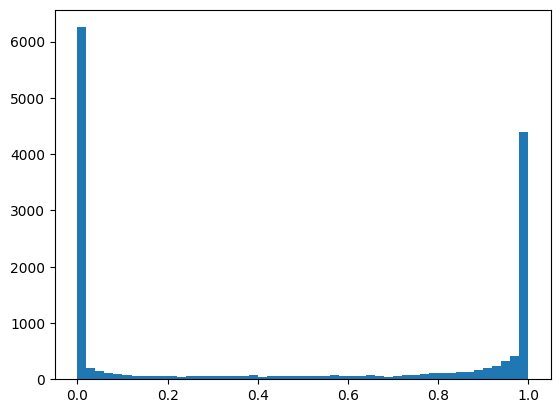

In [4]:
import matplotlib.pyplot as plt

plt.hist(ood_train_feature_scores, range=[0,1], bins=50)
plt.show()

In [5]:
siameseTrain = load_embedding('siameseResnetTrain.tsv')
print(siameseTrain.shape)

siameseTest = load_embedding('siameseResnetTest.tsv')
print(siameseTest.shape)

(10677, 128)
(4502, 128)


In [6]:

ood = OutOfDistribution()

ood_train_feature_scores = ood.fit_score(features=siameseTrain)
ood_test_feature_scores = ood.score(features=siameseTest)

Fitting OOD estimator based on provided features ...


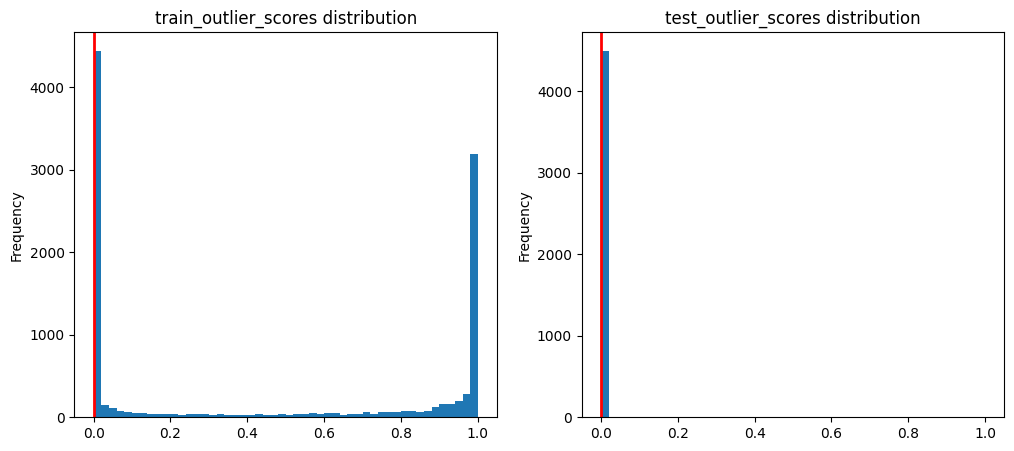

In [7]:
fifth_percentile = np.percentile(ood_train_feature_scores, 5)  # 5th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(ood_train_feature_scores.min(),ood_test_feature_scores.min()), \
             max(ood_train_feature_scores.max(),ood_test_feature_scores.max())]
axes[0].hist(ood_train_feature_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile, color='red', linewidth=2)
axes[1].hist(ood_test_feature_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile, color='red', linewidth=2)


output.mp4
Fitting OOD estimator based on provided features ...


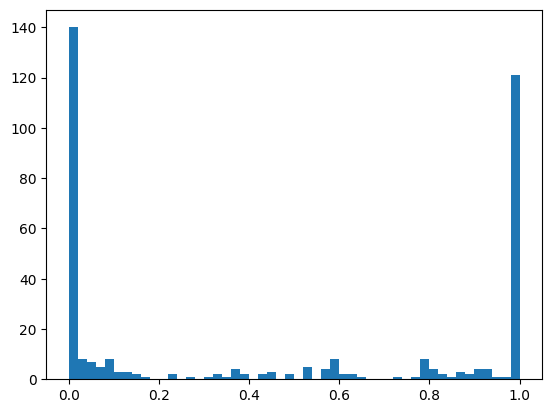

Airbnb.mp4
Fitting OOD estimator based on provided features ...


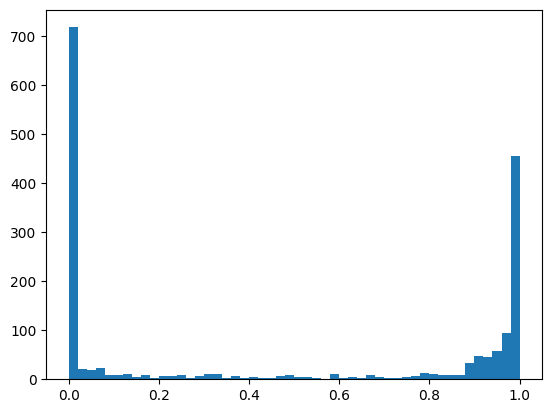

pedidosya.mp4
Fitting OOD estimator based on provided features ...


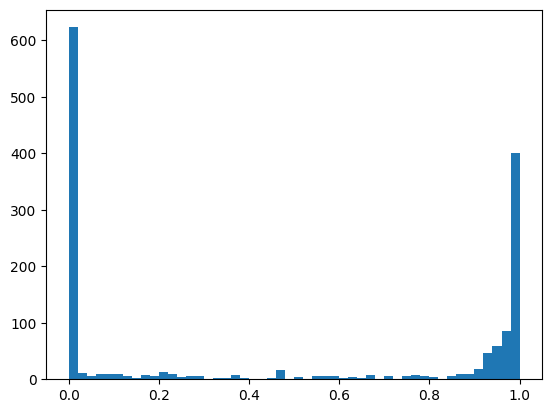

wikipedia.mp4
Fitting OOD estimator based on provided features ...


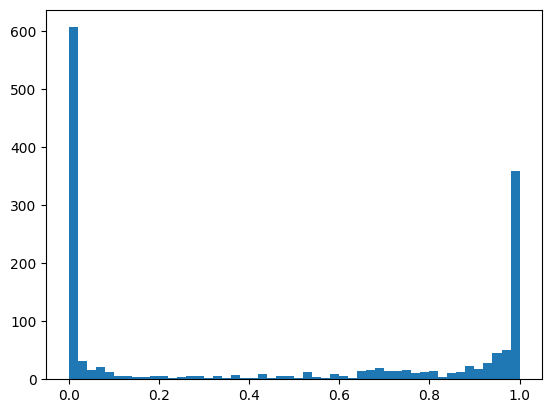

CNN_posts.mp4
Fitting OOD estimator based on provided features ...


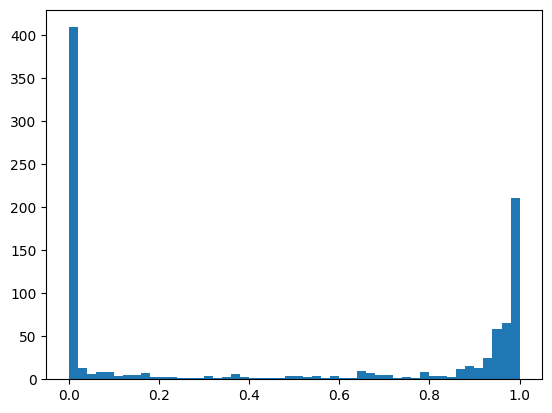

PS_unistall.mp4
Fitting OOD estimator based on provided features ...


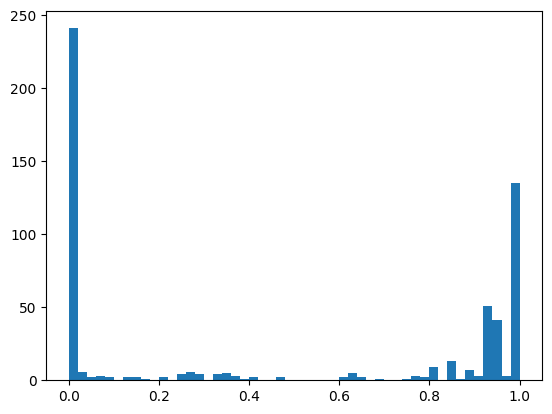

Pinterest_view_save.mp4
Fitting OOD estimator based on provided features ...


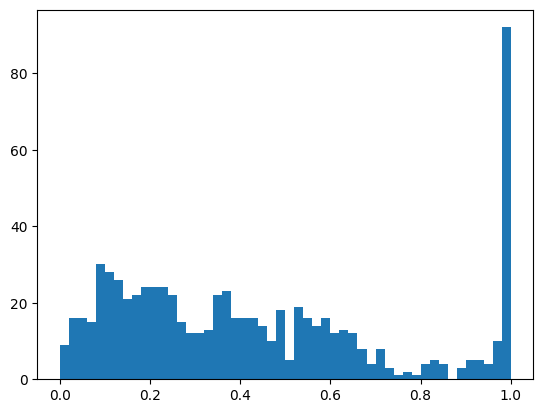

X_twitter_comment.mp4
Fitting OOD estimator based on provided features ...


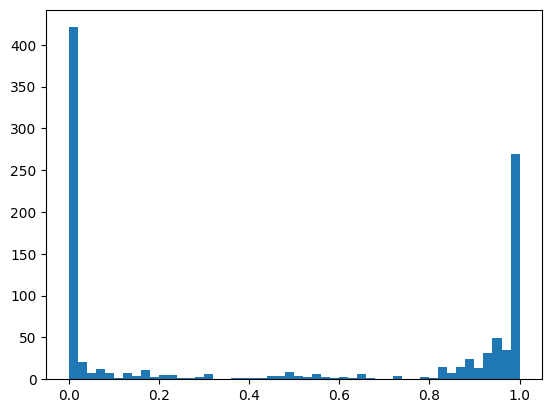

X_unfollow.mp4
Fitting OOD estimator based on provided features ...


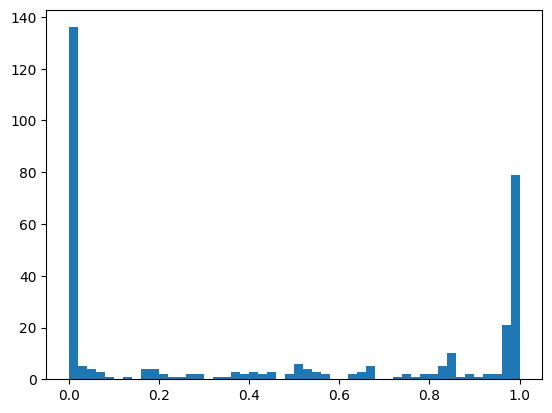

X_follow_notification.mp4
Fitting OOD estimator based on provided features ...


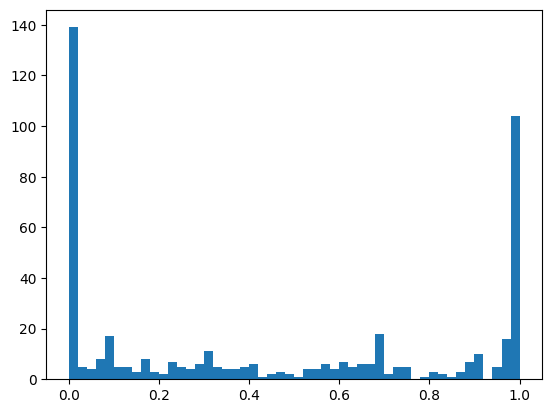

meli_1.mp4.mp4
Fitting OOD estimator based on provided features ...


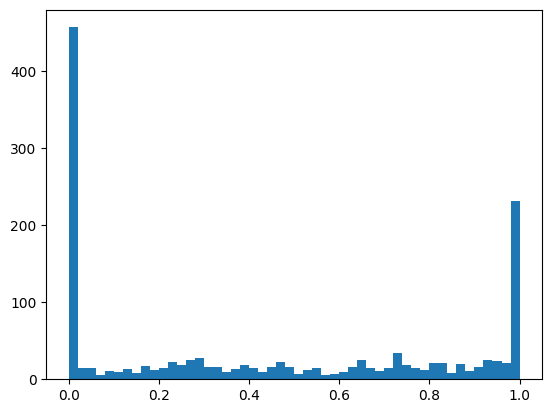

In [8]:
from validation import TRAIN_SIAMESE_DATASET

def embeddingsFilter(video, interval=None):
    def f(tagged_embedding):
        (_, v_video, v_interval), _ = tagged_embedding
        if interval:
            return interval == v_interval and v_video == video
        return video == v_video
    return f

def getEmbeddings(tagged_embedding):
    _, embedding = tagged_embedding
    return embedding

videos = list(TRAIN_SIAMESE_DATASET.keys())
siames_labels = load_labels('embedding_tags.tsv')[1:]

def show_outliers_by_video(embeddings, labels, videos):
    embeddings_by_label = list(zip(labels, list(embeddings)))
    for video in videos:
        videoFilter = embeddingsFilter(video)
        video_tagged_embeddings = filter(videoFilter, embeddings_by_label)
        video_embeddings = list(map(getEmbeddings, video_tagged_embeddings))
        video_embeddings = np.array(video_embeddings)
        print(video)
        ood = OutOfDistribution()
        ood_train_feature_scores = ood.fit_score(features=video_embeddings)
        plt.hist(ood_train_feature_scores, range=[0,1], bins=50)
        plt.show()

show_outliers_by_video(siameseTrain, siames_labels, videos)


output.mp4 Product Added to Cart
Fitting OOD estimator based on provided features ...


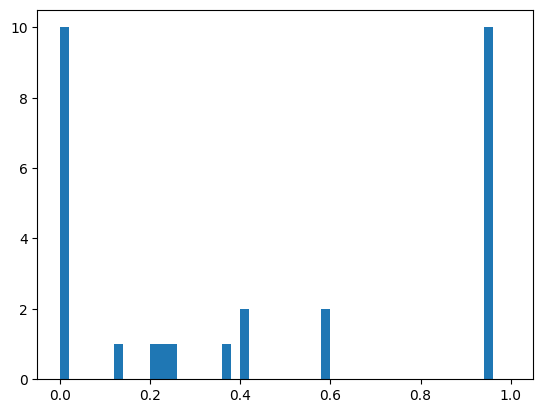

output.mp4 Product View
Fitting OOD estimator based on provided features ...


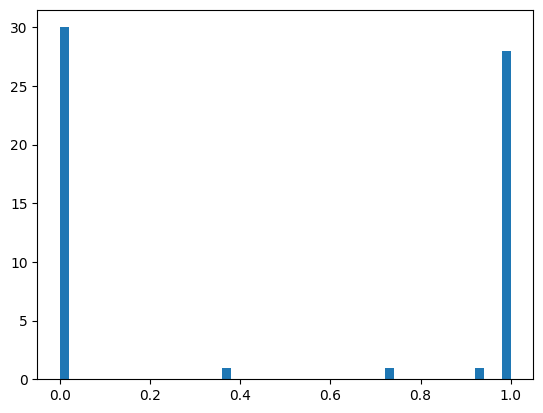

output.mp4 Bugs
Fitting OOD estimator based on provided features ...


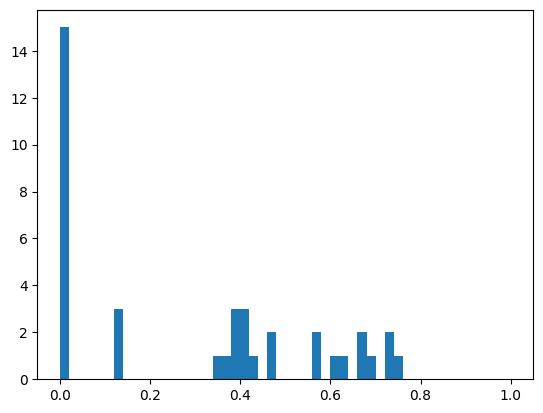

output.mp4 Crashed App (Black)
Fitting OOD estimator based on provided features ...


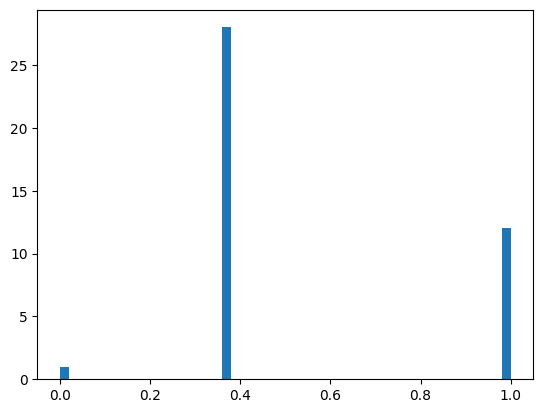

output.mp4 Home
Fitting OOD estimator based on provided features ...


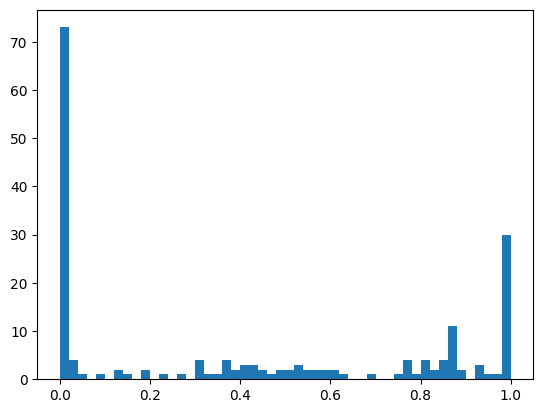

Airbnb.mp4 Selext Destination
Fitting OOD estimator based on provided features ...


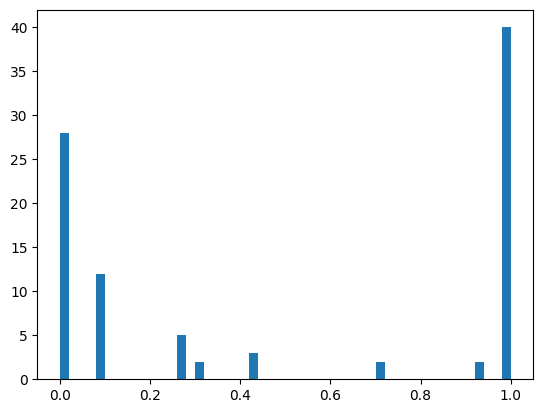

Airbnb.mp4 Write Destination
Fitting OOD estimator based on provided features ...


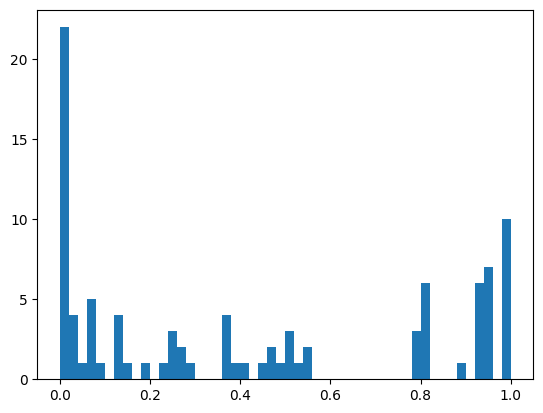

Airbnb.mp4 Add to Wish List
Fitting OOD estimator based on provided features ...


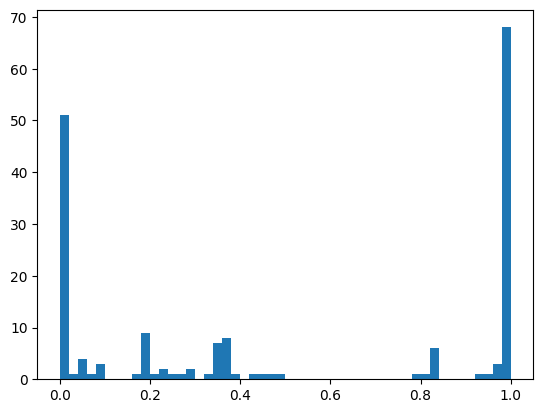

Airbnb.mp4 Translation Message
Fitting OOD estimator based on provided features ...


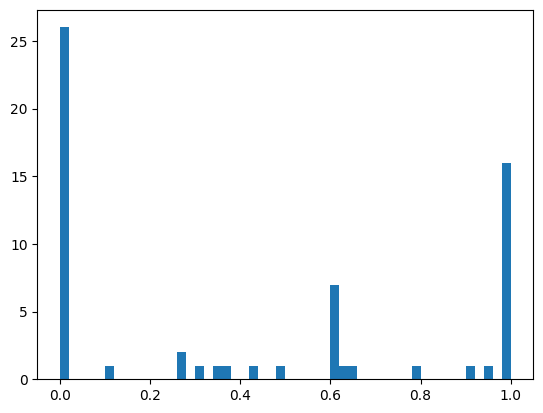

Airbnb.mp4 Select Date
Fitting OOD estimator based on provided features ...


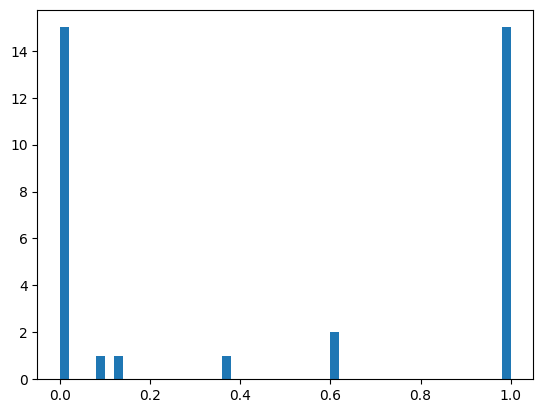

Airbnb.mp4 Edit Wishlist
Fitting OOD estimator based on provided features ...


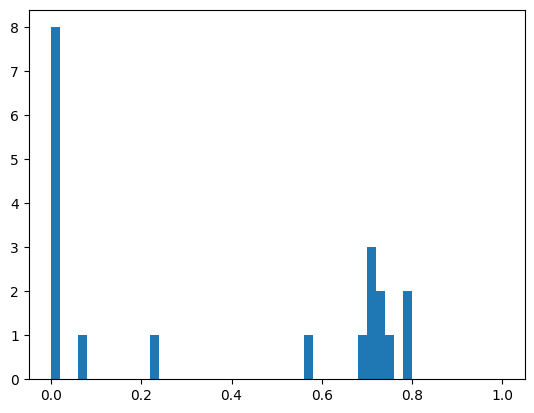

Airbnb.mp4 Search Destinations
Fitting OOD estimator based on provided features ...


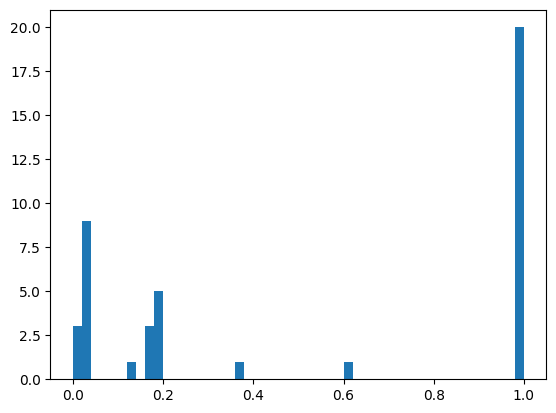

Airbnb.mp4 Select Persons
Fitting OOD estimator based on provided features ...


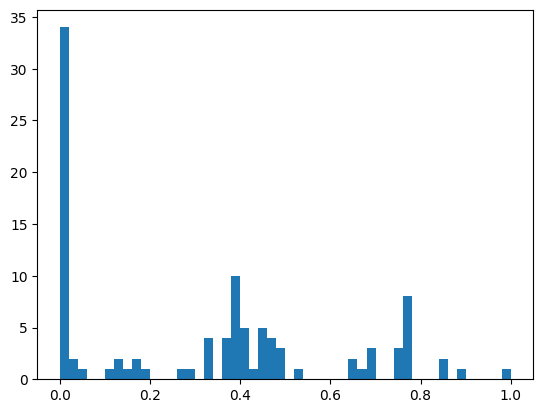

Airbnb.mp4 Product View
Fitting OOD estimator based on provided features ...


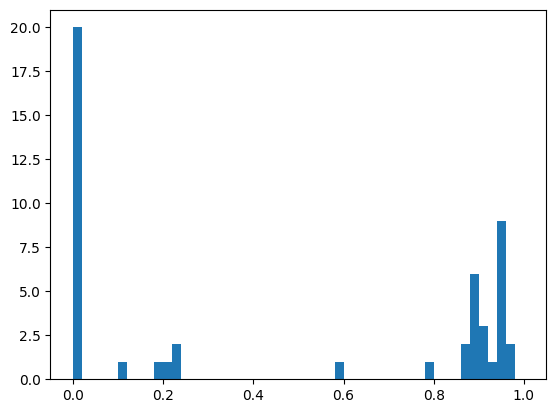

Airbnb.mp4 Home
Fitting OOD estimator based on provided features ...


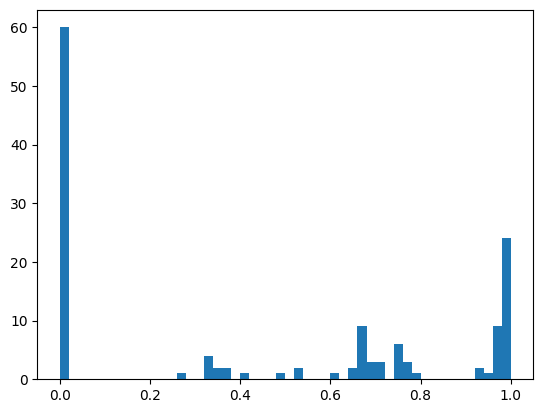

Airbnb.mp4 Delete Wishlist
Fitting OOD estimator based on provided features ...


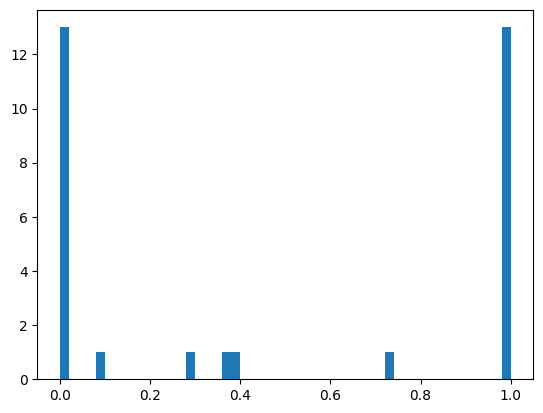

Airbnb.mp4 Create Wish List
Fitting OOD estimator based on provided features ...


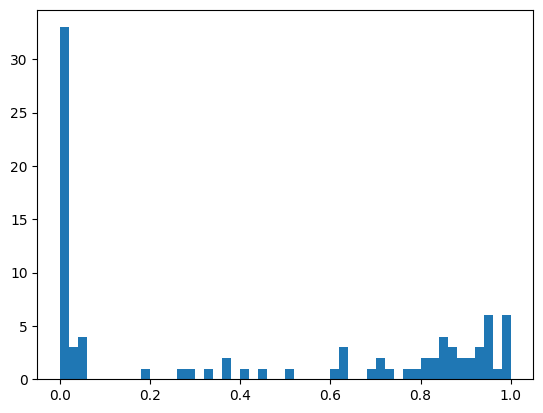

Airbnb.mp4 Product Added
Fitting OOD estimator based on provided features ...


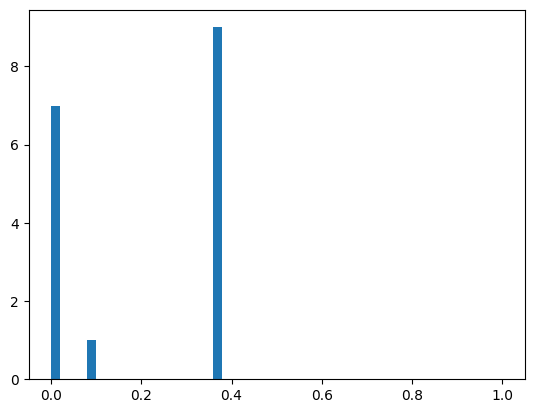

Airbnb.mp4 Delete whishlist
Fitting OOD estimator based on provided features ...


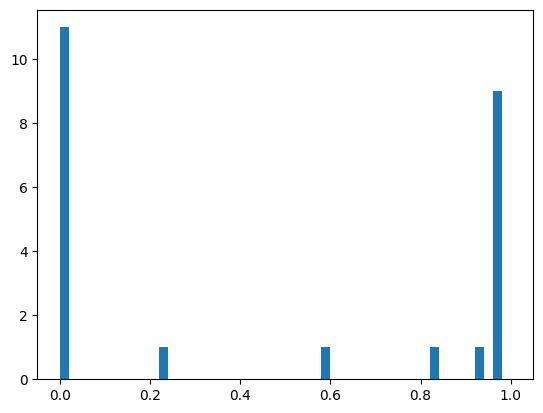

Airbnb.mp4 Wishlists
Fitting OOD estimator based on provided features ...


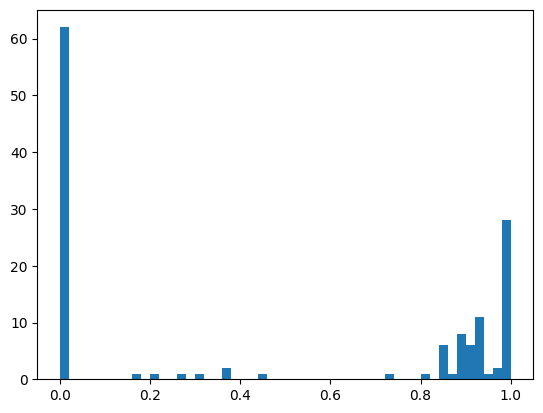

Airbnb.mp4 Edit Whislists
Fitting OOD estimator based on provided features ...


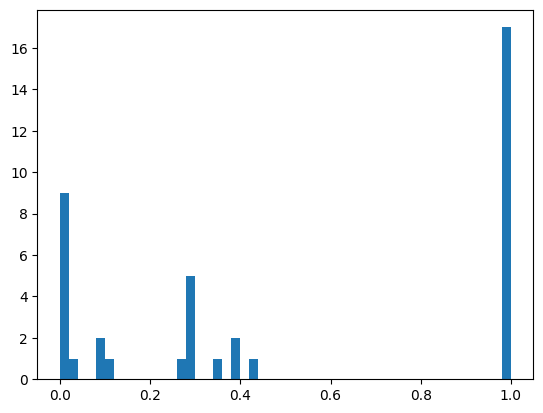

Airbnb.mp4 Product Added to Wish List
Fitting OOD estimator based on provided features ...


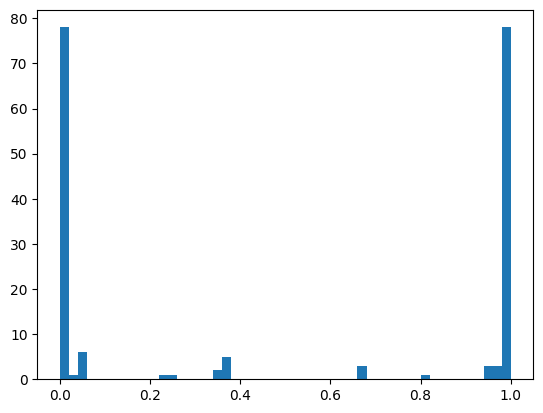

Airbnb.mp4 Select Date 2
Fitting OOD estimator based on provided features ...


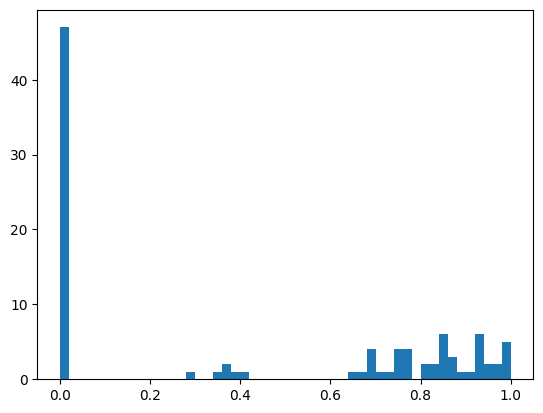

Airbnb.mp4 Places View
Fitting OOD estimator based on provided features ...


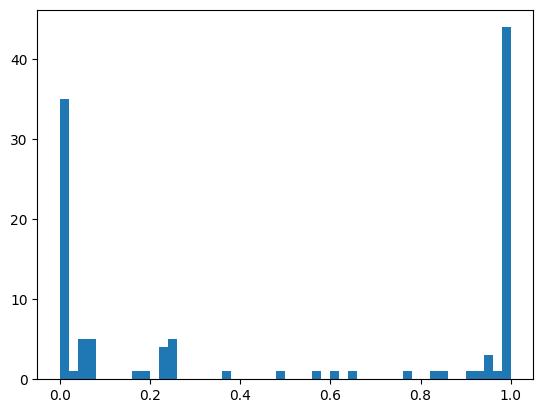

Airbnb.mp4 Wishlist
Fitting OOD estimator based on provided features ...


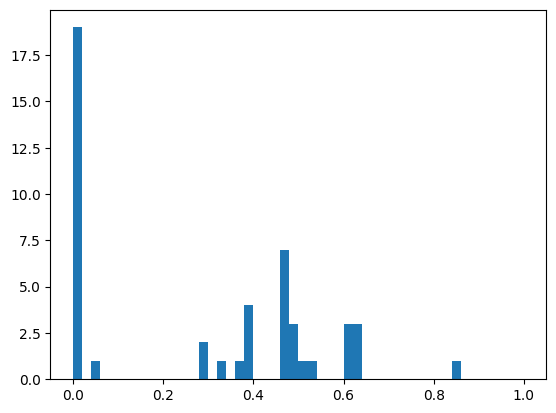

Airbnb.mp4 Wish Item
Fitting OOD estimator based on provided features ...


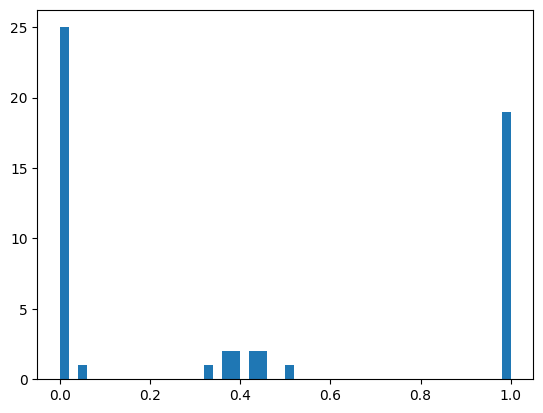

Airbnb.mp4 List of items
Fitting OOD estimator based on provided features ...


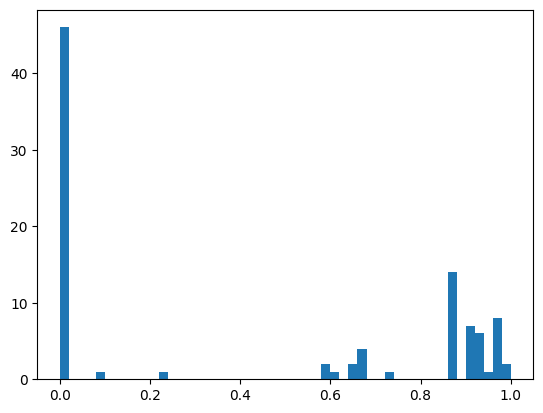

pedidosya.mp4 Product view
Fitting OOD estimator based on provided features ...


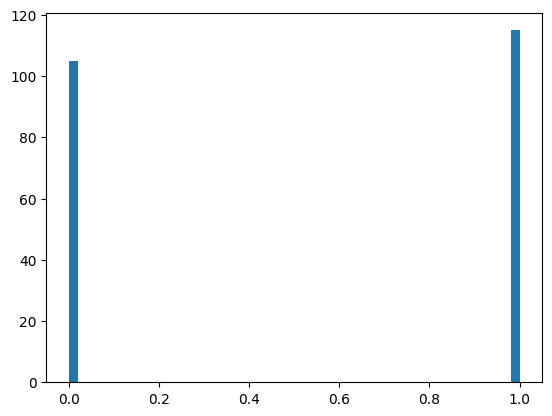

pedidosya.mp4 Confirm Order
Fitting OOD estimator based on provided features ...


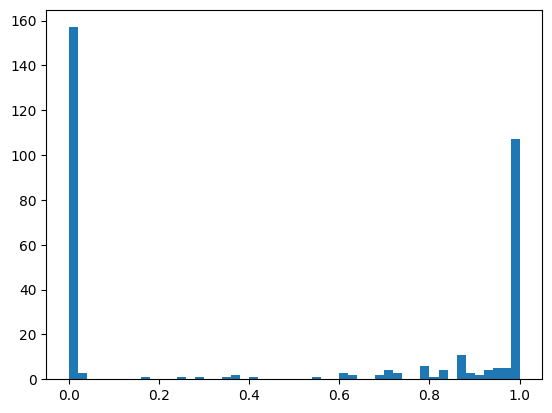

pedidosya.mp4 Payment method
Fitting OOD estimator based on provided features ...


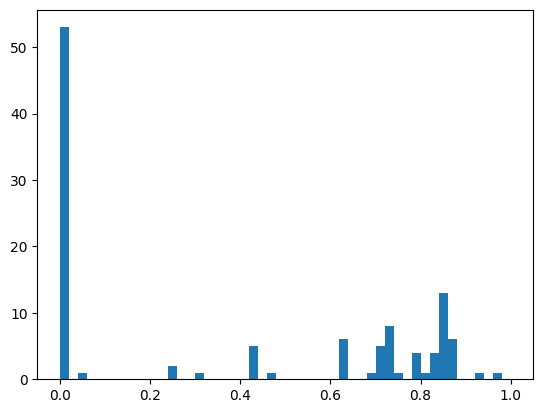

pedidosya.mp4 Alert
Fitting OOD estimator based on provided features ...


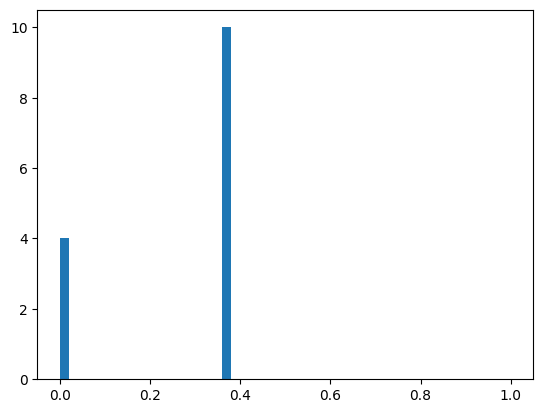

pedidosya.mp4 Restaurant view
Fitting OOD estimator based on provided features ...


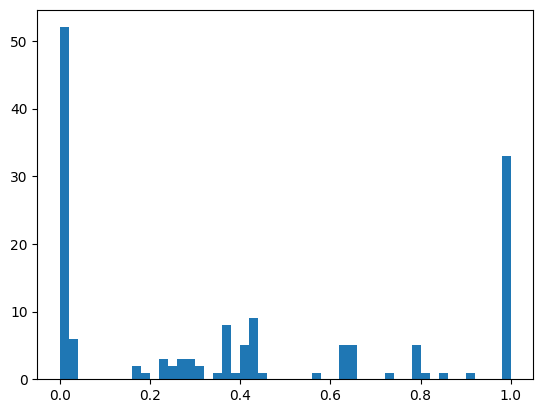

pedidosya.mp4 Restaurant menu
Fitting OOD estimator based on provided features ...


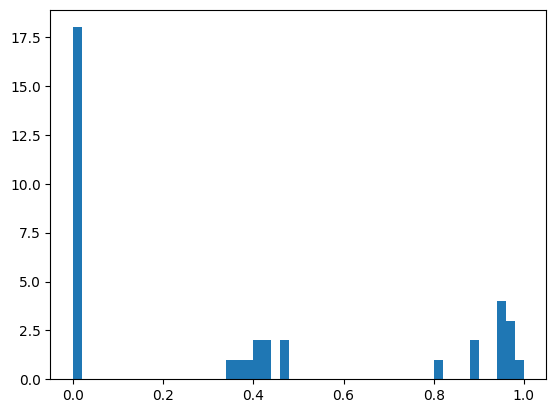

pedidosya.mp4 Home
Fitting OOD estimator based on provided features ...


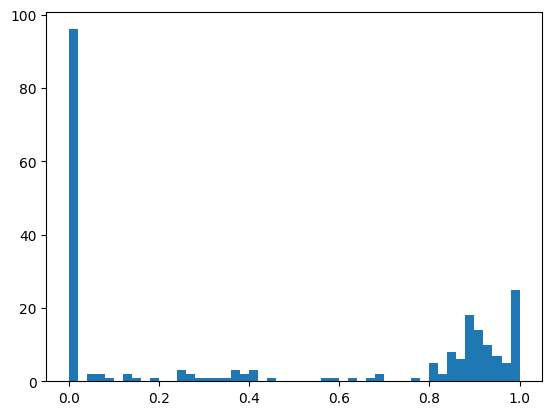

pedidosya.mp4 Order summary
Fitting OOD estimator based on provided features ...


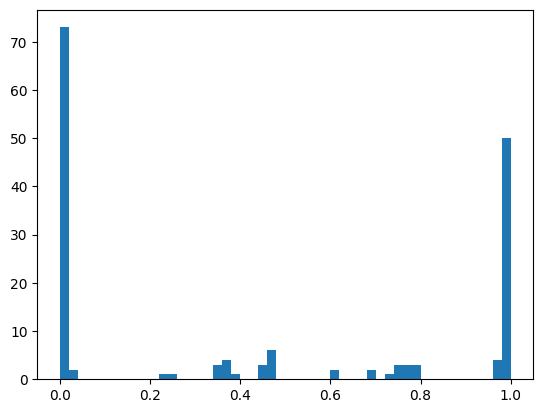

pedidosya.mp4 Restaurant menu view
Fitting OOD estimator based on provided features ...


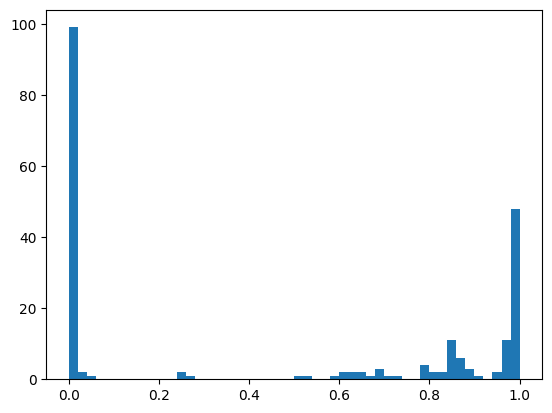

wikipedia.mp4 Topic Information Screen
Fitting OOD estimator based on provided features ...


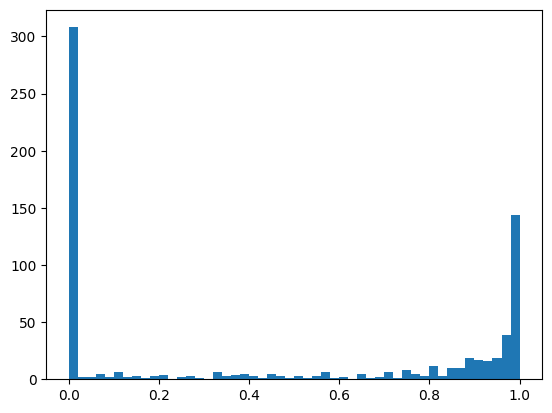

wikipedia.mp4 Topic Information and View Saved List
Fitting OOD estimator based on provided features ...


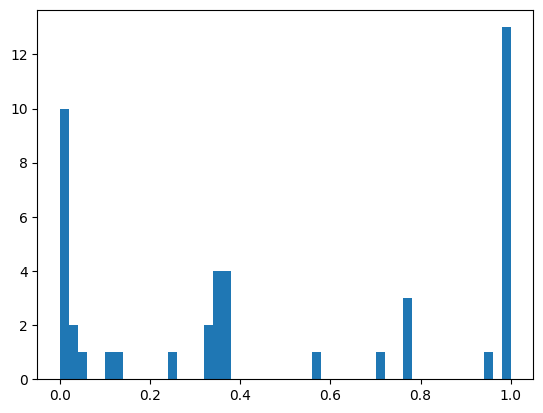

wikipedia.mp4 Search History
Fitting OOD estimator based on provided features ...


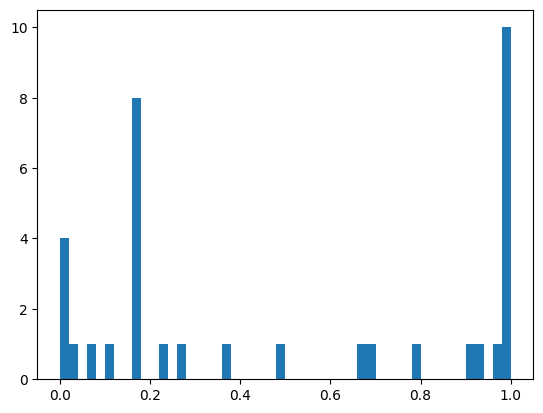

wikipedia.mp4 Saved List
Fitting OOD estimator based on provided features ...


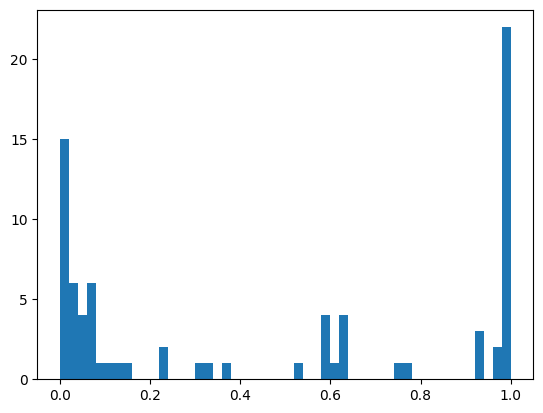

wikipedia.mp4 Search Histoy
Fitting OOD estimator based on provided features ...


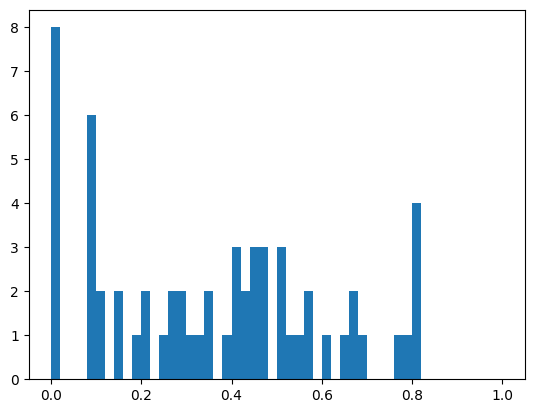

wikipedia.mp4 Home
Fitting OOD estimator based on provided features ...


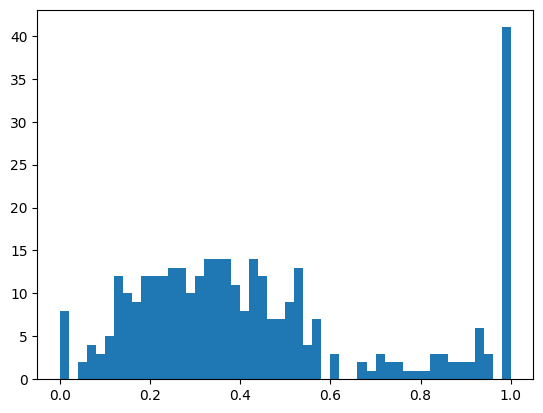

wikipedia.mp4 Save Topics Options
Fitting OOD estimator based on provided features ...


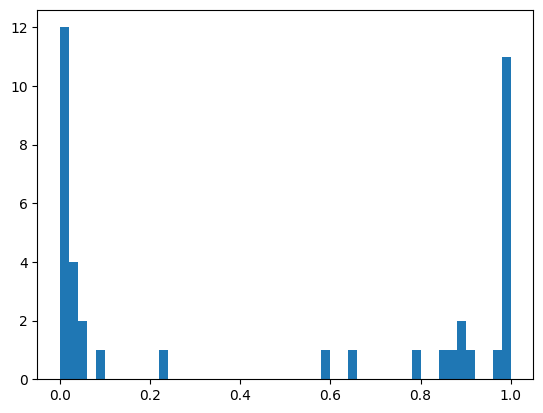

wikipedia.mp4 List of topics
Fitting OOD estimator based on provided features ...


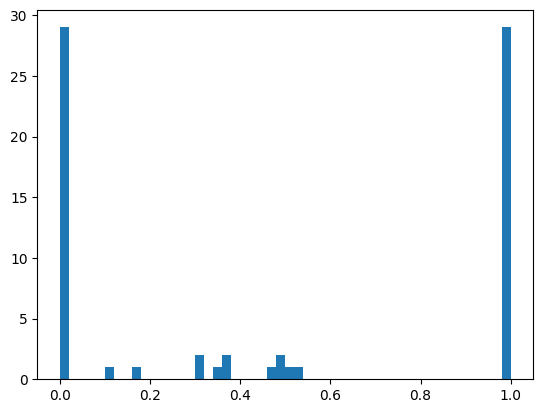

wikipedia.mp4 Save Options
Fitting OOD estimator based on provided features ...


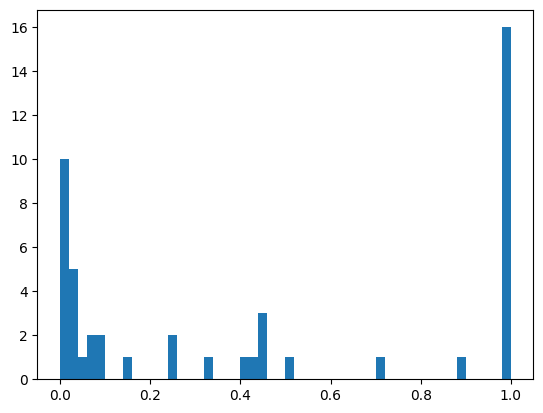

CNN_posts.mp4 Settings
Fitting OOD estimator based on provided features ...


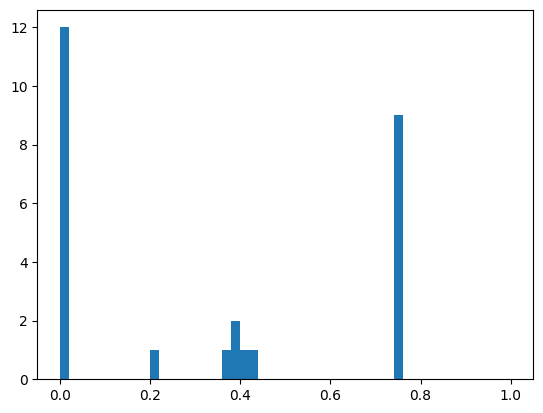

CNN_posts.mp4 Post
Fitting OOD estimator based on provided features ...


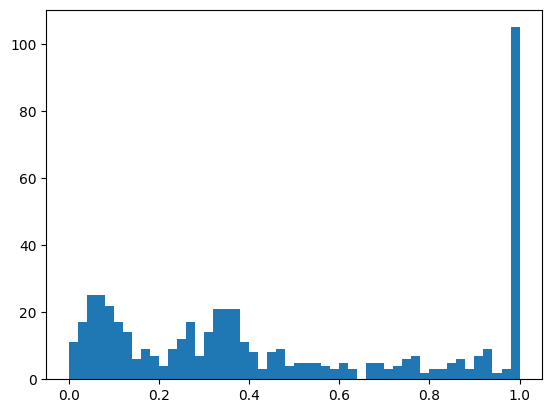

CNN_posts.mp4 Alerts Options
Fitting OOD estimator based on provided features ...


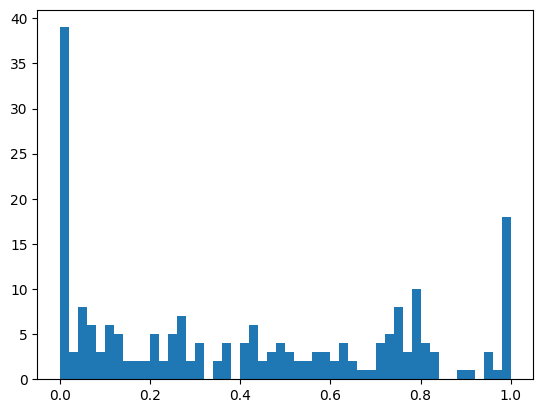

CNN_posts.mp4 Alerts
Fitting OOD estimator based on provided features ...


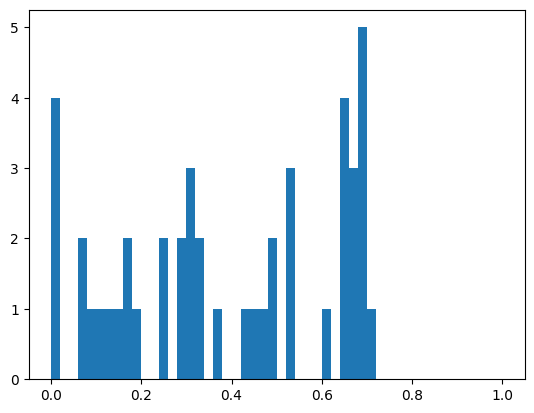

CNN_posts.mp4 Home
Fitting OOD estimator based on provided features ...


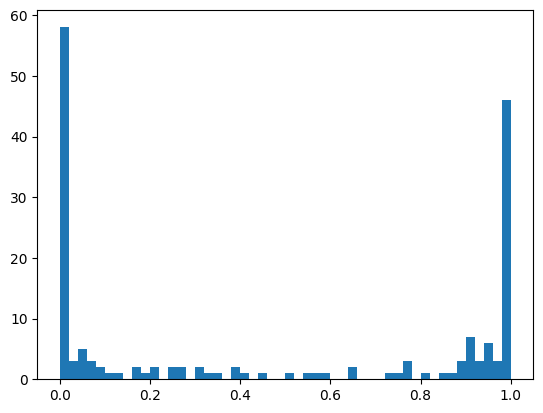

PS_unistall.mp4 Home
Fitting OOD estimator based on provided features ...


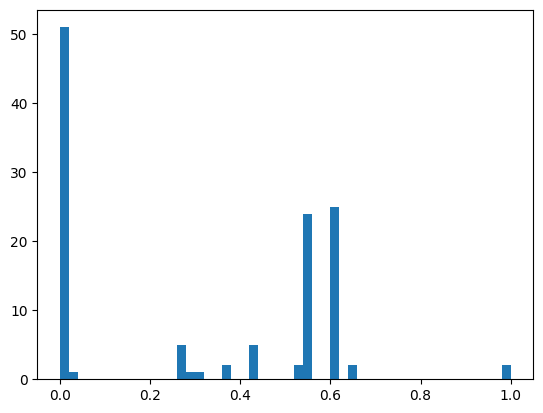

PS_unistall.mp4 Uninstall confirmation message
Fitting OOD estimator based on provided features ...


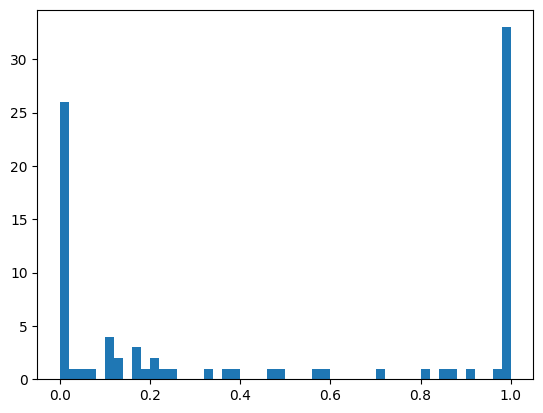

PS_unistall.mp4 App Menu
Fitting OOD estimator based on provided features ...


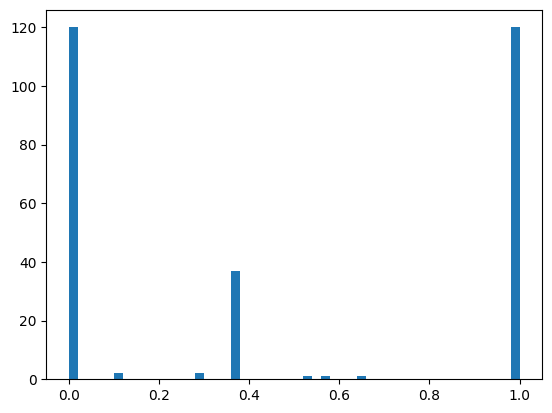

PS_unistall.mp4 PS Home
Fitting OOD estimator based on provided features ...


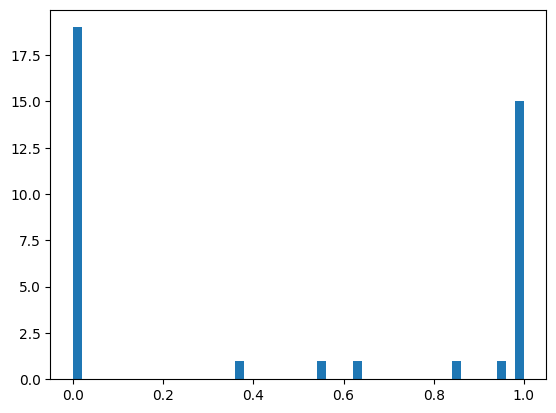

Pinterest_view_save.mp4 Pinterest_Home
Fitting OOD estimator based on provided features ...


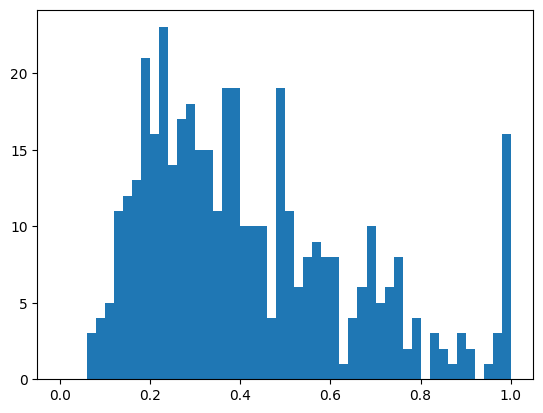

Pinterest_view_save.mp4 Post Screen
Fitting OOD estimator based on provided features ...


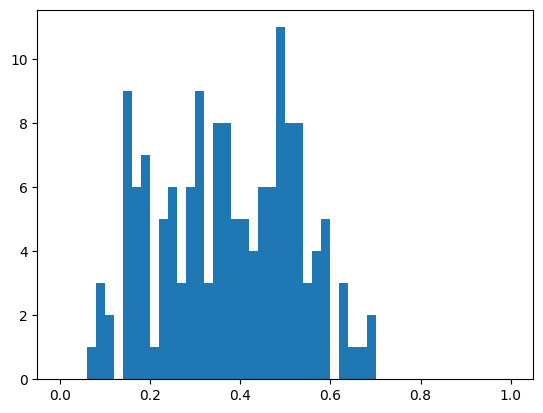

Pinterest_view_save.mp4 List of posts
Fitting OOD estimator based on provided features ...


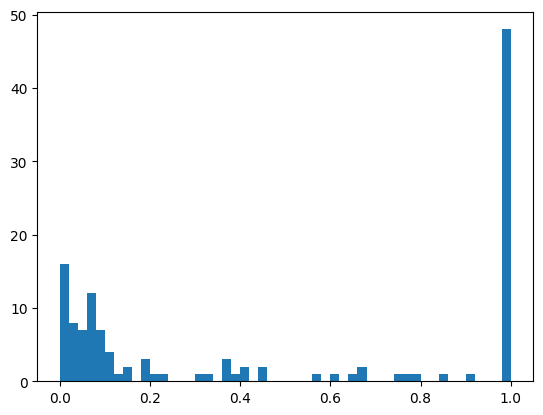

X_twitter_comment.mp4 Comments
Fitting OOD estimator based on provided features ...


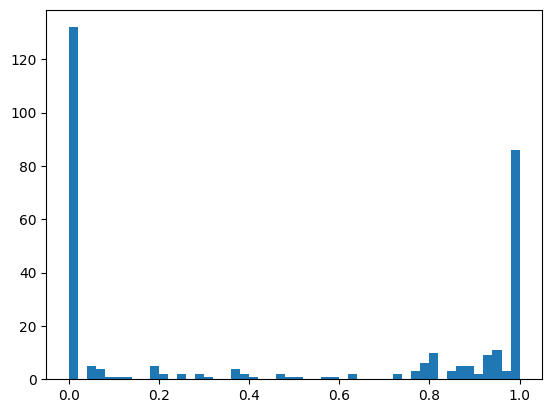

X_twitter_comment.mp4 Home
Fitting OOD estimator based on provided features ...


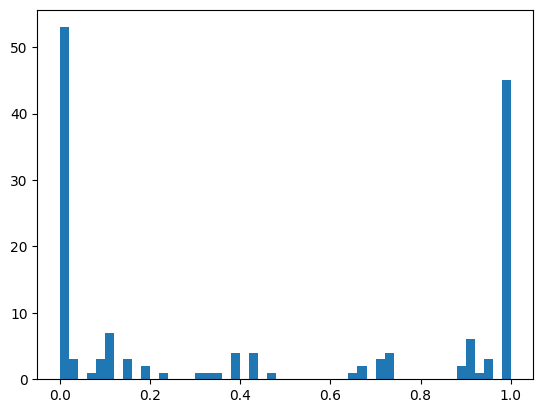

X_twitter_comment.mp4 Post
Fitting OOD estimator based on provided features ...


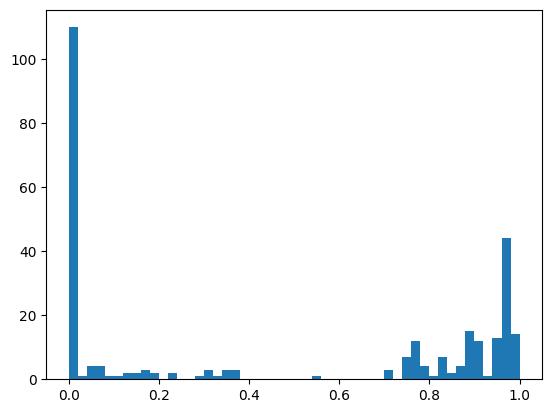

X_twitter_comment.mp4 Bookmarks
Fitting OOD estimator based on provided features ...


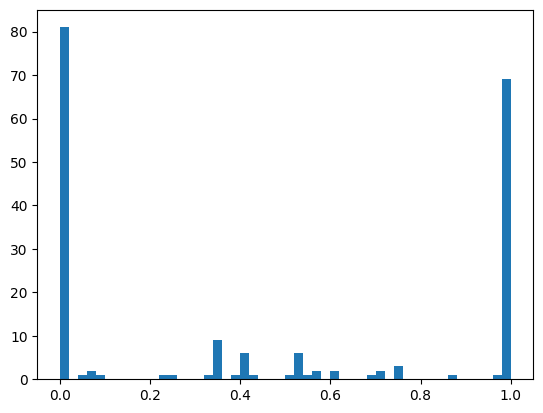

X_twitter_comment.mp4 Clear Bookmarks
Fitting OOD estimator based on provided features ...


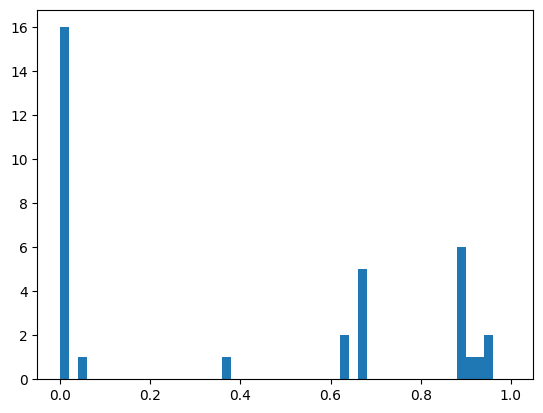

X_twitter_comment.mp4 Post options
Fitting OOD estimator based on provided features ...


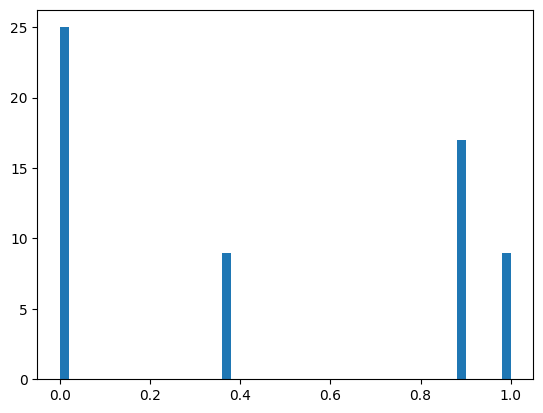

X_unfollow.mp4 Unfollow confirmation message
Fitting OOD estimator based on provided features ...


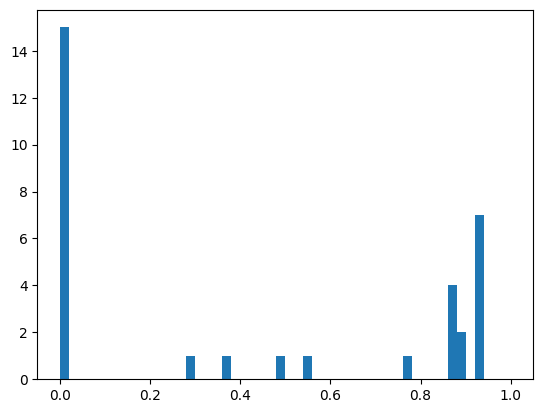

X_unfollow.mp4 X_Home
Fitting OOD estimator based on provided features ...


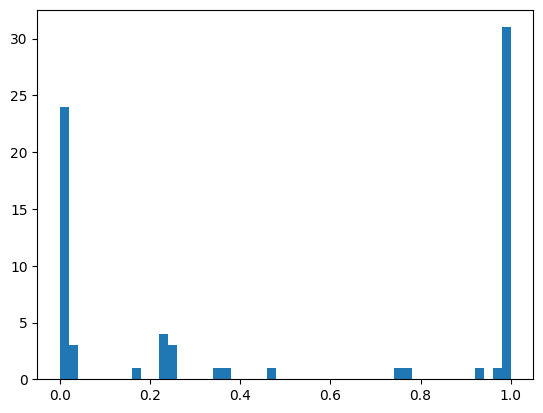

X_unfollow.mp4 User Profile
Fitting OOD estimator based on provided features ...


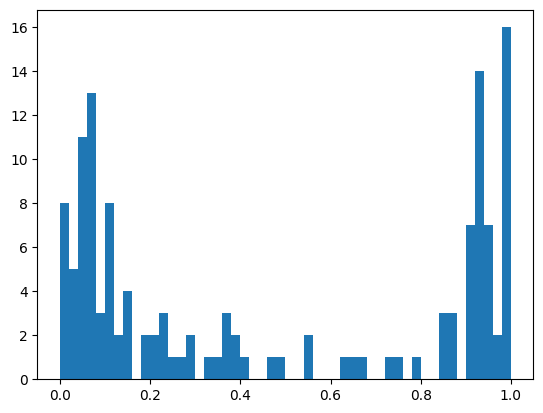

X_follow_notification.mp4 Profile
Fitting OOD estimator based on provided features ...


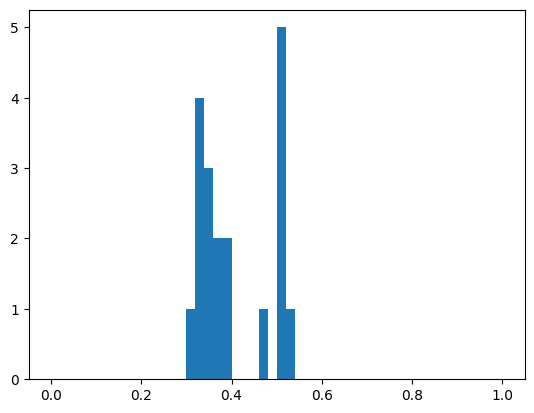

X_follow_notification.mp4 Profile Home
Fitting OOD estimator based on provided features ...


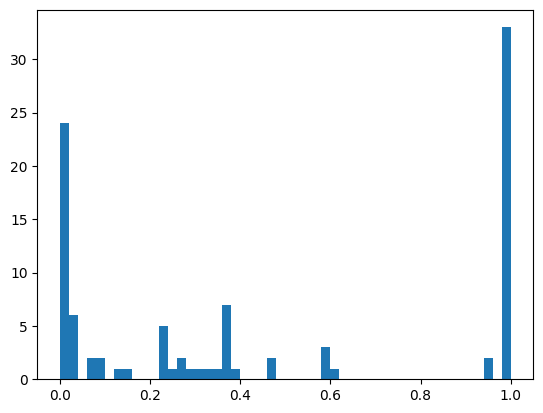

X_follow_notification.mp4 Notifications options
Fitting OOD estimator based on provided features ...


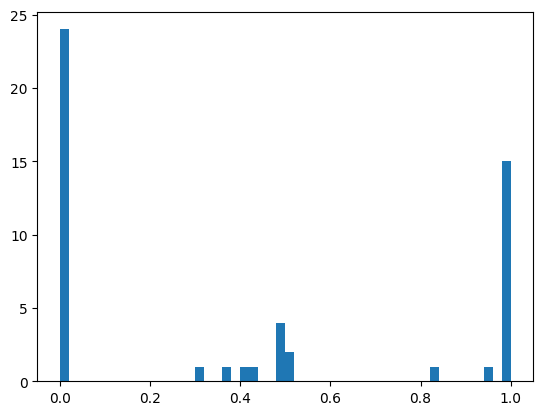

X_follow_notification.mp4 User settings
Fitting OOD estimator based on provided features ...


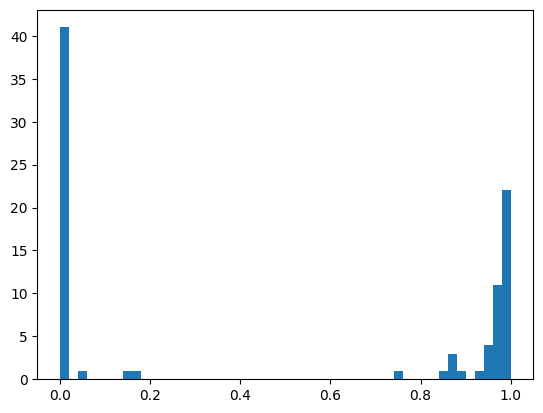

X_follow_notification.mp4 X_home
Fitting OOD estimator based on provided features ...


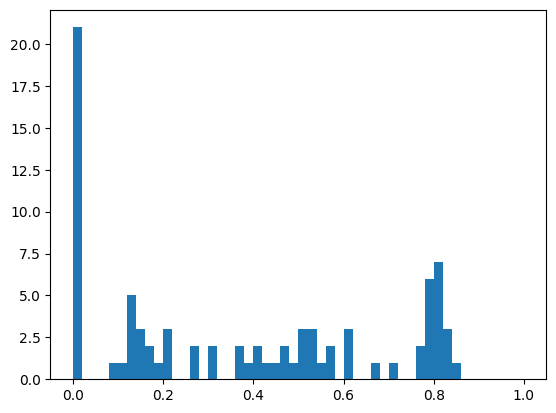

X_follow_notification.mp4 Added Profile
Fitting OOD estimator based on provided features ...


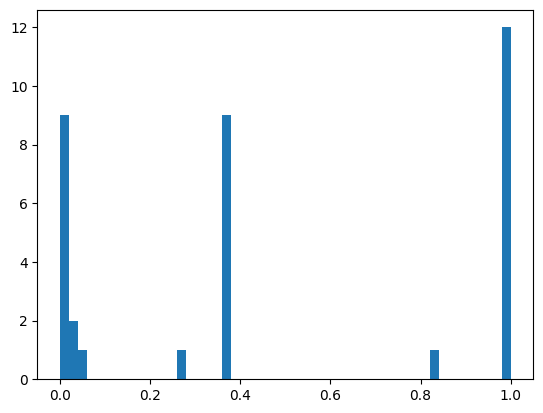

meli_1.mp4.mp4 item added to cart screen
Fitting OOD estimator based on provided features ...


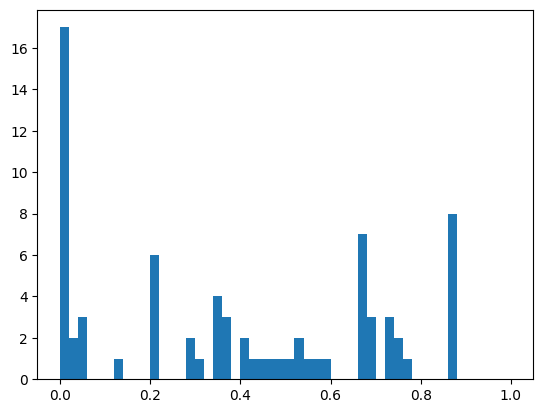

meli_1.mp4.mp4 item screen
Fitting OOD estimator based on provided features ...


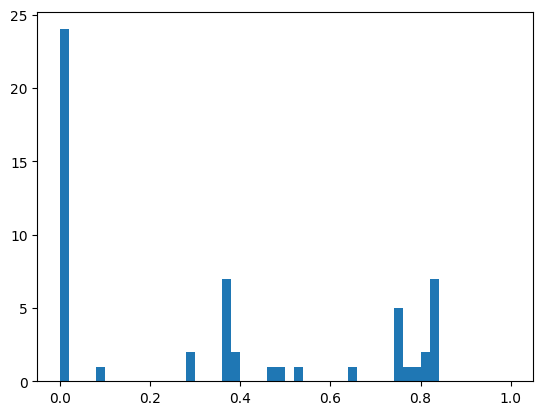

meli_1.mp4.mp4 product details
Fitting OOD estimator based on provided features ...


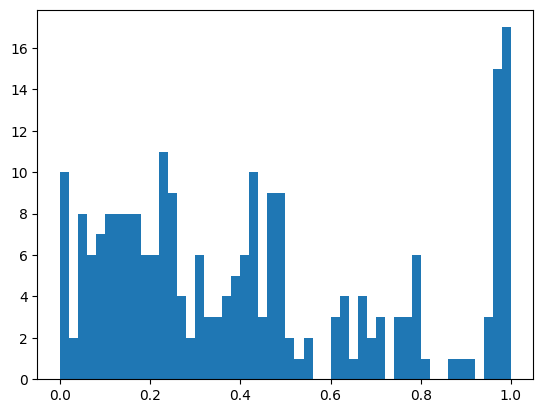

meli_1.mp4.mp4 Hamburguer menu
Fitting OOD estimator based on provided features ...


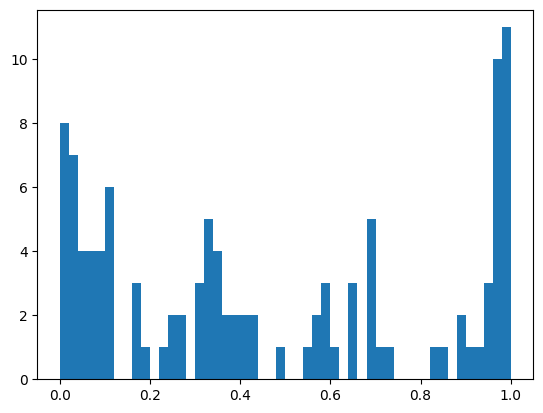

meli_1.mp4.mp4 meli_home
Fitting OOD estimator based on provided features ...


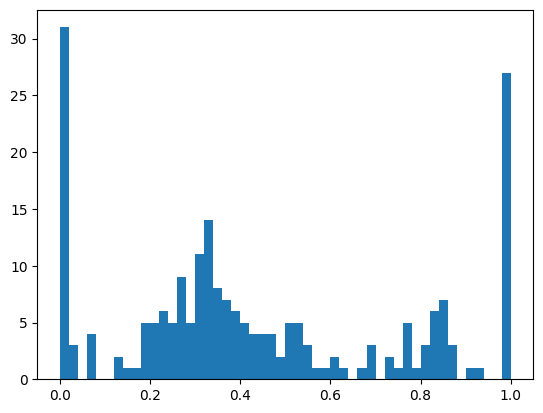

meli_1.mp4.mp4 cart screen
Fitting OOD estimator based on provided features ...


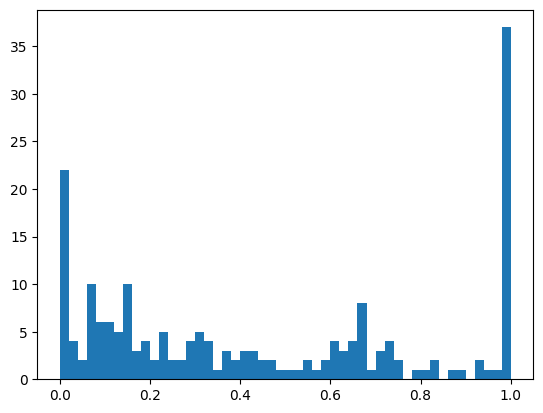

meli_1.mp4.mp4 item added to cart
Fitting OOD estimator based on provided features ...


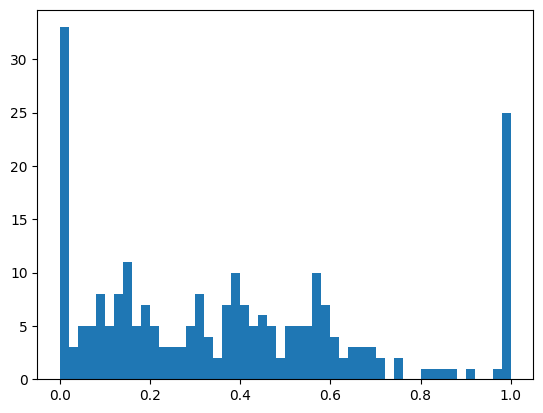

meli_1.mp4.mp4 search screen
Fitting OOD estimator based on provided features ...


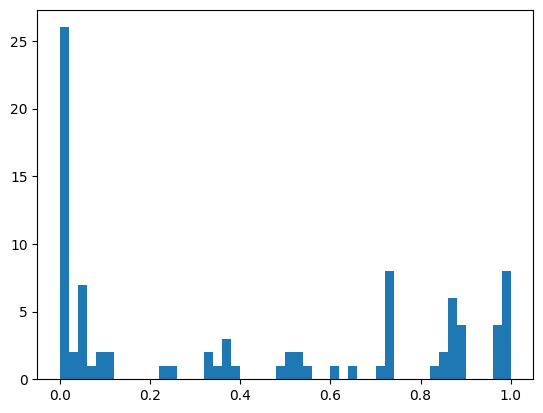

meli_1.mp4.mp4 list of options items
Fitting OOD estimator based on provided features ...


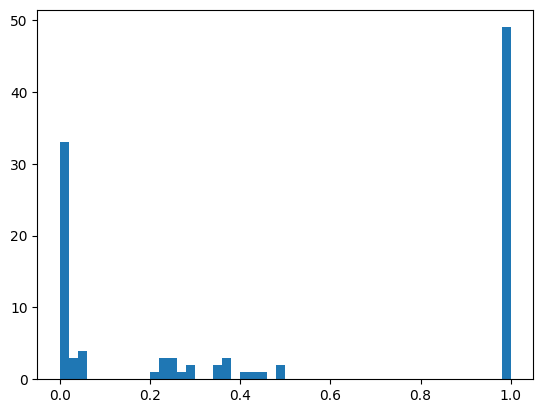

meli_1.mp4.mp4 list items
Fitting OOD estimator based on provided features ...


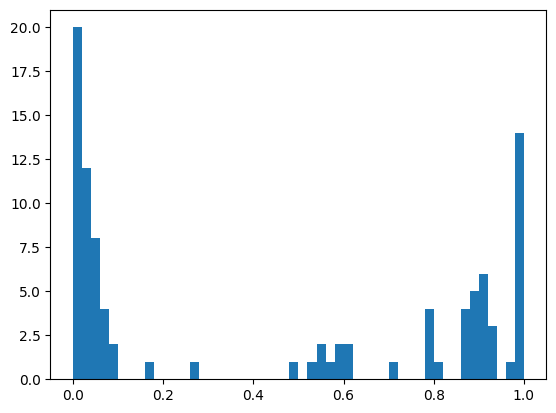

In [9]:
def plot_otliers_by_interval(video, interval, embeddings, labels):
    embeddings_by_label = list(zip(labels, list(embeddings)))
    videoFilter = embeddingsFilter(video, interval)
    video_tagged_embeddings = filter(videoFilter, embeddings_by_label)
    video_embeddings = list(map(getEmbeddings, video_tagged_embeddings))
    video_embeddings = np.array(video_embeddings)
    print(video, interval)
    ood = OutOfDistribution()
    ood_train_feature_scores = ood.fit_score(features=video_embeddings)
    plt.hist(ood_train_feature_scores, range=[0,1], bins=50)
    plt.show()

def show_outliers_by_intervals(embeddings, labels, videos, dataset):
    for video in videos:
        intervals = dataset[video]
        interval_names = list(set(map(lambda x: x[2], intervals)))
        for interval in interval_names:
            plot_otliers_by_interval(video, interval, embeddings, labels)

show_outliers_by_intervals(siameseTrain, siames_labels, videos, TRAIN_SIAMESE_DATASET)

In [12]:
yolo_curated = load_embedding('yolo-curated.tsv')
ood = OutOfDistribution()

ood_train_feature_scores = ood.fit_score(features=yolo_curated)

Fitting OOD estimator based on provided features ...


In [ ]:
plt.hist(ood_train_feature_scores, range=[0,1], bins=50)
plt.show()